In [2]:
# -*- coding: utf-8 -*-
# 导入所需的python库
import time;import datetime
# from time import time
from pandas.tseries.offsets import MonthEnd,Day
from itertools import combinations
import pandas as pd; import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
data_path = r'D:\比赛数据\360rong'.decode('utf-8').encode('gbk')
title = 'r360'

In [3]:
import os  
mingw_path = 'C:\Program Files\mingw-w64\x86_64-5.3.0-posix-seh-rt_v4-rev0\mingw64\bin'  
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost as xgb

# Load Data
1. user_info: select occupation,education
2. bank_detail: convert timestamp type to string with 年月日 ,时间空值用中位数代替
3. browse_history:数据太大，导入后直接做预处理,browse_data:1-216,browse_tag:1-11
4. bill_detail:66697
5. loan_time

train: 55597个用户  test:  3898  train+test: 69495个用户

In [22]:
def load_data1():
    # user_info# 读取数据集
    user_info_train = pd.read_csv(r'{}\train\user_info_train.txt'.format(data_path), header = None)
    user_info_test = pd.read_csv(r'{}\test\user_info_test.txt'.format(data_path),header = None)
    col_names = ['userid', 'sex', 'occupation', 'education', 'marriage', 'household'] # id 性别 职业,教育程度,婚姻状态,户口类型
    user_info_train.columns = col_names; user_info_test.columns = col_names
    user_info = pd.concat([user_info_train, user_info_test])
#     user_info.index = user_info['userid']; user_info.drop('userid',axis = 1,inplace = True)

    # loan_time
    loan_time_train = pd.read_csv(r'{}\train\loan_time_train.txt'.format(data_path),header = None)
    loan_time_test = pd.read_csv(r'{}\test\loan_time_test.txt'.format(data_path), header = None)
    loan_time = pd.concat([loan_time_train, loan_time_test])
    loan_time.columns = ['userid', 'loan_time']
#     loan_time = loan_time.set_index('userid')
    loan_time['loan_time'] = loan_time.loan_time.map(lambda i:datetime.datetime.fromtimestamp(i))
    
#     load_data = user_info.join(loan_time,how='outer')
    return user_info,loan_time

def load_data2():
    # bank_detail
    bank_detail_train = pd.read_csv(r'{}\train\bank_detail_train.txt'.format(data_path), header = None)
    bank_detail_test = pd.read_csv(r'{}\test\bank_detail_test.txt'.format(data_path), header = None)
    col_names = ['userid', 'tm_encode', 'trade_type', 'trade_amount', 'salary_tag']# 用户id，时间戳、交易类型、交易金额、工资收入标记
    bank_detail_train.columns = col_names; bank_detail_test.columns = col_names
    bank_detail = pd.concat([bank_detail_train, bank_detail_test])
#     bank_detail['tm_encode'][bank_detail.tm_encode==0] = bank_detail.tm_encode.median()
    bank_detail['tm_encode'] = bank_detail.tm_encode.map(lambda i:datetime.datetime.fromtimestamp(i))
#     bank_detail['tm_encode'] = [time.strftime("%Y-%m-%d",time.localtime(da)) for da in bank_detail.tm_encode ]
#     print r'银行流水账号：用户id，时间戳、交易类型、交易金额、工资收入标记';print bank_detail.head(5)
#     bank_detail = bank_detail.set_index('userid')
    return bank_detail

def load_data3():
    # browse_history
    browse_history_train = pd.read_csv(r'{}\train\browse_history_train.txt'.format(data_path),header = None)
    browse_history_test = pd.read_csv(r'{}\test\browse_history_test.txt'.format(data_path),header = None)
    col_names = ['userid', 'tm_encode_2', 'browse_data', 'browse_tag']
    browse_history_train.columns = col_names; browse_history_test.columns = col_names
    browse_history = pd.concat([browse_history_train, browse_history_test])
    del browse_history_test,browse_history_train
    browse_history['tm_encode_2'] = browse_history.tm_encode_2.map(lambda i:datetime.datetime.fromtimestamp(i))
#     browse_history = browse_history.set_index('userid')
    return browse_history

def load_data4():
    # bill_detail 信用卡账单记录
    bill_detail_train = pd.read_csv(r'{}\train\bill_detail_train.txt'.format(data_path),header = None)
    bill_detail_test = pd.read_csv(r'{}\test\bill_detail_test.txt'.format(data_path), header = None)
    # 用户id，账单时间戳、银行id、上期账单金额、上期还款金额、信用卡额度、本期账余额、本期账单最低还款额、
    #消费笔数,本期账单金额、调整金额，循环利息、可用余额、预借金额额度、还款状态
    col_names = ['userid', 'tm_encode_3', 'bank_id', 'prior_account', 'prior_repay', 'credit_limit', 'account_balance','minimun_repay', 
                 'consume_count', 'account', 'adjust_account', 'circulated_interest', 'avaliable_balance', 'cash_limit', 'repay_state']
    bill_detail_train.columns = col_names; bill_detail_test.columns = col_names
    bill_detail = pd.concat([bill_detail_train, bill_detail_test])
#     bill_detail['tm_encode_3'][bill_detail.tm_encode_3 == 0] = bill_detail.tm_encode_3.median()
#     bill_detail['tm_encode_3'] = [time.strftime("%Y-%m-%d",time.localtime(da)) for da in bill_detail.tm_encode_3 ]
    bill_detail.tm_encode_3 = bill_detail.tm_encode_3.map(lambda i:datetime.datetime.fromtimestamp(i))
#     bill_detail = bill_detail.set_index('userid')
    return bill_detail

# 根据贷款时间前60天划分数据
def shaixuan_byTime(load_data,time_name,shift=30): 
    loan_data = load_data[load_data[time_name]>(load_data['loan_time']-shift*Day())]
    loan_data = loan_data.drop('loan_time',axis=1)
    return loan_data


In [23]:
user_info,loan_time = load_data1()
bill_detail =load_data4()
bill_detail_t30 = shaixuan_byTime(pd.merge(bill_detail,loan_time,on='userid',how='left'),'tm_encode_3',30)
print r'==================user和bill===================='
print r'user总的用户量:',user_info.shape[0]
print r'bill_detail的用户量为:',len(set(bill_detail.userid))
print r'bill_detail前loan_time30days用户量：',len(set(bill_detail_t30.userid))
print '================bank====================='
bank_detail = load_data2()
bank_detail_t30 = shaixuan_byTime(pd.merge(bank_detail,loan_time,on='userid',how='left'),'tm_encode',30)
print r'bank_detail的用户量：',len(set(bank_detail.userid))
print r'bank_detail前loan_time的30days用户量：',len(set(bank_detail_t30.userid))
print '=================bank并bill===================='
print r'bank和bill合集大小',len(set(bank_detail.userid).union(set(bill_detail.userid)))
print r'bank和bill前30天合集大小',len(set(bank_detail.userid).union(set(bill_detail_t30.userid)))
print r'bank前30天和bill前30天合集大小',len(set(bank_detail_t30.userid).union(set(bill_detail_t30.userid)))
print r'==================browse=================='
browse_history = load_data3()
print r'browse_history的用户量',len(set(browse_history.userid))

==================user和bill====================
user总的用户量: 69495
bill_detail的用户量为: 66817
bill_detail前loan_time30days用户量： 57566
================bank=====================
bank_detail的用户量： 10003
bank_detail前loan_time的30days用户量： 6852
=================bank并bill====================
bank和bill合集大小 69019
bank和bill前30天合集大小 61317
bank前30天和bill前30天合集大小 60114
==================browse==================
browse_history的用户量 59327


In [45]:
# 针对测试集的统计
def test_len(data):
    return len([i for i in list(data) if i>=55597])
print r'==================user和bill测试集===================='
print r'test,user测试集总的用户量:',test_len(set(user_info.userid))
print r'bill_detail的测试集用户量为:',test_len(set(bill_detail.userid))
print r'bill_detail前loan_time30days测试集用户量：',test_len(set(bill_detail_t30.userid))
print '================bank测试集====================='
print r'bank_detail的测试集用户量：',test_len(set(bank_detail.userid))
print r'bank_detail前loan_time的30days测试集用户量：',test_len(set(bank_detail_t30.userid))
print '=================bank并bill测试集===================='
print r'bank和bill测试集合集大小',test_len(set(bank_detail.userid).union(set(bill_detail.userid)))
print r'bank和bill前30天测试集合集大小',test_len(set(bank_detail.userid).union(set(bill_detail_t30.userid)))
print r'bank前30天和bill前30天测试集合集大小',test_len(set(bank_detail_t30.userid).union(set(bill_detail_t30.userid)))
print r'==================browse测试集=================='
print r'browse_history的测试集用户量',test_len(set(browse_history.userid))

==================user和bill测试集====================
test,user测试集总的用户量: 13899
bill_detail的测试集用户量为: 13643
bill_detail前loan_time30days测试集用户量： 11381
================bank测试集=====================
bank_detail的测试集用户量： 709
bank_detail前loan_time的30days测试集用户量： 0
=================bank并bill测试集====================
bank和bill测试集合集大小 13839
bank和bill前30天测试集合集大小 11748
bank前30天和bill前30天测试集合集大小 11381
==================browse测试集==================
browse_history的测试集用户量 11997


对bill做划分，取前30天的数据，先分训练集和测试集，然后用训练集中bill的userid作为index删除空值用户

### Summarize Data
Get univariate summary statistics of data:
* Non-NA values for all variables
* The 5 most frequent values for all variables
* Mean, standard error, and quantiles for numeric variables

In [144]:
def Value_counts(das, nhead = 5):
    tmp = pd.value_counts(das).reset_index().rename_axis({"index": das.name}, axis = 1)
    value = pd.DataFrame(['value {}'.format(x+1) for x in range(nhead)], index = np.arange(nhead)).join(tmp.iloc[:,0], how = "left").set_index(0).T
    freq = pd.DataFrame(['freq {}'.format(x+1) for x in range(nhead)], index = np.arange(nhead)).join(tmp.iloc[:,1], how = "left").set_index(0).T
    nnull = das.isnull().sum()
    freqother = pd.DataFrame({das.name: [das.shape[0]-nnull-np.nansum(freq.values), nnull]}, index = ["freq others", "freq NA"]).T
    op = pd.concat([value, freq, freqother], axis = 1)
    return(op)
def Summary(da):
    op = pd.concat([pd.DataFrame({"type": da.dtypes, "n": da.notnull().sum(axis = 0)}), da.describe().T.iloc[:,1:], 
                    pd.concat(map(lambda i: Value_counts(da.loc[:,i]), da.columns))], axis = 1).loc[da.columns]
    op.index.name = "Columns"
    return(op)


In [179]:
t= Summary(data)
t

,n,type,mean,std,min,25%,50%,75%,max,value 1,...,value 3,value 4,value 5,freq 1,freq 2,freq 3,freq 4,freq 5,freq others,freq NA
Columns,,,,,,,,,,,,,,,,,,,,,
bill_bankid_count,56530,int64,2.398196,1.684118,1.000000,1.000000,2.000000,3.000000,13.000000,1.000000,...,3.000000,4.000000,5.000000,22809.0,13601.0,8300.0,5102.0,3146.0,3572.0,0.0
bill_limitSum,56530,float64,47.364056,33.491117,-18.500000,20.300000,39.000000,60.800000,271.000000,16.900000,...,20.700000,19.500000,19.100000,4159.0,2895.0,2246.0,1753.0,1489.0,43988.0,0.0
bill_limitMean,56530,float64,25.481261,5.493481,-18.500000,20.300000,26.000000,30.100000,38.900000,16.900000,...,20.700000,19.500000,19.100000,4159.0,2897.0,2246.0,1754.0,1490.0,43984.0,0.0
bill_limitStd,56530,float64,10.993027,11.761903,0.000000,0.020000,9.250000,17.580000,64.450000,0.020000,...,0.030000,0.000000,8.790000,11482.0,5690.0,4074.0,1563.0,569.0,33152.0,0.0
bill_account_std,56530,float64,6.615318,10.177678,0.000000,0.000000,0.540000,11.410000,104.730000,0.000000,...,0.030000,0.020000,0.040000,23044.0,238.0,169.0,166.0,148.0,32765.0,0.0
bill_account_pctSum,56530,float64,0.037847,5.693672,-786.651000,-0.023000,0.000000,0.008000,917.542000,0.000000,...,0.001000,-0.001000,0.002000,24633.0,1864.0,260.0,207.0,191.0,29375.0,0.0
bill_account_pctSumAbs,56530,float64,0.394173,5.680137,0.000000,0.000000,0.015000,0.473000,917.542000,0.000000,...,0.001000,0.002000,0.003000,24633.0,1869.0,467.0,364.0,318.0,28879.0,0.0
bill_account_monthAvg,56530,float64,24.087944,19.745903,-21.000000,13.800000,19.900000,33.800000,179.500000,0.000000,...,19.500000,19.100000,20.200000,10095.0,771.0,714.0,640.0,567.0,43743.0,0.0
bill_minimunRepay_pctSum,56530,float64,0.211013,3.697168,-813.257000,-0.002000,0.000000,0.134000,157.062000,0.000000,...,-0.001000,0.002000,-1.000000,18731.0,562.0,444.0,436.0,388.0,35969.0,0.0


In [162]:
browse_pro.loc[55597:,:]

,browse_count,browse_countAvgMon,browse_meanAvgMon,browse_tag_1,browse_tag_2,browse_tag_3,browse_tag_4,browse_tag_5,browse_tag_6,browse_tag_7,browse_tag_8,browse_tag_9,browse_tag_10,browse_tag_11
userid,,,,,,,,,,,,,,
55597,384,77.0,115.0,200.0,0.0,0.0,56.0,16.0,24.0,64.0,0.0,0.0,24.0,0.0
55598,3840,183.0,117.0,1888.0,0.0,0.0,632.0,376.0,248.0,336.0,184.0,0.0,176.0,0.0
55601,1048,116.0,119.0,496.0,0.0,0.0,176.0,136.0,72.0,88.0,8.0,0.0,72.0,0.0
55602,1008,202.0,113.0,444.0,0.0,0.0,120.0,144.0,48.0,108.0,36.0,0.0,108.0,0.0
55603,144,144.0,118.0,56.0,0.0,0.0,24.0,32.0,8.0,16.0,0.0,0.0,8.0,0.0
55604,430,143.0,113.0,220.0,0.0,0.0,60.0,30.0,30.0,60.0,0.0,0.0,30.0,0.0
55605,952,238.0,119.0,462.0,0.0,0.0,112.0,84.0,56.0,112.0,70.0,0.0,56.0,0.0
55606,531,59.0,67.0,279.0,0.0,0.0,99.0,9.0,45.0,90.0,0.0,0.0,9.0,0.0
55607,784,87.0,105.0,344.0,0.0,0.0,112.0,64.0,64.0,88.0,24.0,0.0,88.0,0.0


In [24]:
# browse_detail = load_data3()
# browse_detail   browse_data', 'browse_tag
# print browse_detail.columns
# browse_detail['tm_yearMonth'] = browse_detail.tm_encode_2.map(lambda i:i.strftime('%Y-%m'))
# browse_detail = browse_detail.reset_index()
# browse_detail.drop('tm_encode_2',axis=1,inplace=True)
# browse_detail[['userid','']]

browse_detail.set_index(['userid','tm_yearMonth'])

browse_data  browse_tag
userid tm_yearMonth                         
34801  2157-10               173           1
       2157-10               164           4
       2157-10                38           7
       2157-10                45           1
       2157-10               110           7
       2157-10               118           1
       2157-10                50           6
       2157-10               139           4
       2157-10                82           1
       2157-10               101           1
       2157-01               173           1
       2157-01                82           1
       2157-01                53           1
       2157-01               139           4
       2157-01               190          10
       2157-01                50           6
       2157-01               118           1
       2157-01                80           1
       2157-01                45           1
       2157-01               120           1
       2157-01                38           7
       2157-01               164           4
       2157-09               139           4
       2157-09                45           1
       2157-09               110           7
       2157-09               118           1
       2157-09               173           1
       2157-09                82           1
       2157-09                50           6
       2157-09               189           1
...                          ...         ...
68917  2157-09                44           5
       2157-09               139           4
       2157-09               167           8
       2157-09               110           7
       2157-09               173           1
       2157-09               164           4
       2157-09               101           1
       2157-09               120           1
       2157-09                38           7
       2157-09               189           1
       2157-09               190          10
       2157-09                45           1
       2157-09               118           1
       2157-09                82           1
       2158-01               189           1
       2158-01                38           7
       2158-01                50           6
       2158-01               190          10
       2158-01                44           5
       2158-01               139           4
       2158-01               167           8
       2158-01                90           5
       2158-01               110           7
       2158-01                45           1
       2158-01               118           1
       2158-01               173           1
       2158-01                82           1
       2158-01               164           4
       2158-01               120           1
       2158-01               101           1

[28395602 rows x 2 columns]

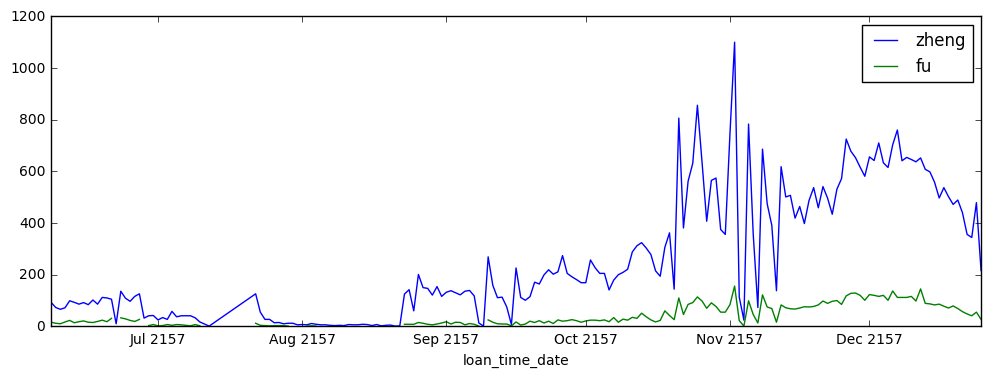

In [105]:
# print bill_detail_t[['bank_id','tm_encode_3','consume_count']].reset_index().set_index(['userid','bank_id','tm_encode_3']).sort_index().head(10)
# bill_detail_t['tm_date'] = bill_detail_t.tm_encode_3.map(lambda i:i.date())
'''
bill_detail_3 = bill_detail_t.reset_index()
bill_pro_3 = bill_detail_3[['userid','bank_id','consume_count','tm_yearMonth']].groupby(['userid','bank_id','tm_yearMonth'])['consume_count'].max()
print bill_pro_3.head(10)
bill_pro_3 = bill_pro_3.sum(level='userid');bill_pro_3.columns='bill_consumeCount_sum'
bill_pro_3['bill_consumeCount_monthAvg'] = bill_pro_3.mean(level='tm_yearMonth')
print bill_pro_3

bill_detail_5a = bill_detail_t.reset_index()
bill_pro_5a = bill_detail_5a[['userid','bank_id','tm_yearMonth','minimun_repay']].groupby(['userid','bank_id','tm_yearMonth'])['minimun_repay'].mean() #去噪
bill_pro_5a = bill_pro_5a.sum(level=['userid','tm_yearMonth']).unstack()
# print bill_pro_5a.head(20)
bill_pro_5= pd.DataFrame([])
bill_pro_5['bill_minimunRepayt_std'] = bill_pro_5a.std(axis=1).round(decimals=2)
bill_pro_5['bill_minimunRepayt_mean'] = bill_pro_5a.mean(axis=1).round(decimals=1)

bill_pro_5b = bill_pro_5a.pct_change(axis=1);bill_pro_5b[bill_pro_5b==np.inf] = 0 # 有inf值,设为0
bill_pro_5['bill_account_pctSum'] = bill_pro_5b.sum(axis=1).round(decimals=3)
# bill_pro_5['bill_account_pctSumAbs'] = bill_pro_5b.sum(axis=1).abs().round(decimals=3)
bill_pro_5 = bill_pro_5.fillna(0)
print bill_pro_5.head(10)
bill_pro_5a.head(20)
'''


# bank_detail_t[bank_detail_t.salary_tag==bank_detail_t.trade_type][bank_detail_t.salary_tag==1]


# 点图
def scatter_plot(data,label):
    data = data.join(label)
    plt.scatter(data.iloc[:,1], data.iloc[:,0])
    plt.ylabel(u"y")                         # 设定纵坐标名称
    plt.grid(b=True, which='major', axis='y') 
    plt.title(u"circulated_interest")
# def 
    
# 利息 与 label    
# bill_su = bill_detail.reset_index()
# tempt = bill_su.loc[:55596,['userid','circulated_interest']].groupby('userid').mean()  
# scatter_plot(tempt,target)
'''# bank_id 与 label
bill_bank = pd.DataFrame(bill_detail.loc[:55596,'bank_id']).join(target)
bill_bank = bill_bank.groupby('bank_id')['label'].value_counts().unstack()
bill_bank.columns = ['zheng','fu']
bill_bank['fubili'] = bill_bank.fu/(bill_bank.zheng+bill_bank.fu)
print bill_bank
bill_detail.bank_id.value_counts()
'''
# loan_time
_,loan_time = load_data1()
loan_time['loan_time_date'] = loan_time.applymap(lambda i:i.date())
loan_time_train = loan_time.loc[:55596,:].reset_index()
loan_time_train = loan_time_train.join(target)
su_loan_time = loan_time_train[['loan_time_date','label']].groupby('loan_time_date')['label'].value_counts().unstack()
su_loan_time.columns = ['zheng','fu']
su_loan_time.plot()
# 利息
# tempt=tempt.join(target)
t_0 = tempt[tempt.label==0]
t_1 = tempt[tempt.label==1]
print t_0.circulated_interest.round(decimals=0).value_counts()/t_0.shape[0]
print t_1.circulated_interest.round(decimals=0).value_counts()/t_1.shape[0]

# Clean Data
processing:
* browse_history 59327个用户
    * （1）groupby(userid)求和、最大值
    * （2）groupby(userid,year-month)求和、平均值，再按照月份求平均
* bank_detail:只给了10003个用户的银行流水账号信息，缺失值非常大，不适合
* bill_detail: 66817个用户

In [156]:
# browse_detail, bank_detail
def browse_pro(browse_history,loan_time):
    browse_history_1 = browse_history.reset_index()
#     browse_detail['tm_yearMonth'] = browse_detail.tm_encode_2.map(lambda i:i.strftime('%Y-%m'))
#     browse_detail['tm_date'] = browse_detail.tm_encode_2.map(lambda i:i.date())
    browse_all = browse_history_1[['userid', 'browse_data']].groupby('userid').count()
    browse_all.columns = ['browse_count']
    # browse_tag_all_count','browse_tag_all_max没用
    
    browse_mon = browse_history_1[['userid', 'tm_encode_2', 'browse_data']].groupby(
        ['userid','tm_encode_2']).agg([('mon_count','count'),('mon_mean','mean')]).fillna(method='ffill')
    browse_avgMon = browse_mon.mean(axis=0,level='userid');browse_avgMon = browse_avgMon.round(decimals=0)
    browse_avgMon.columns = ['browse_countAvgMon','browse_meanAvgMon']
    
#     browse_history_2 = browse_history.join(loan_time)
#     browse_7daysHistory = browse_history_2[browse_history_2.tm_encode_2>=(browse_history_2.loan_time-5*Day())][browse_history_2.tm_encode_2<=(browse_history_2.loan_time+1*Day())]
#     browse_days = browse_7daysHistory[['userid','browse_data']].groupby('userid')['browse_data'].count()
#     browse_days.columns = ['browse_7days_count'];browse_days = pd.DataFrame(browse_days)
#     browse_30daysHistory = browse_history_2[browse_history_2.tm_encode_2>=(browse_history_2.loan_time-15*Day())][browse_history_2.tm_encode_2<=(browse_history_2.loan_time+15*Day())]
#     browse_days['browse_30days_count'] = browse_30daysHistory[['userid','browse_data']].groupby('userid')['browse_data'].count()
    browse_tag = browse_history_1[['userid','browse_tag']].groupby('userid')['browse_tag'].value_counts().unstack().add_prefix('browse_tag_').fillna(0)
    browse_pro = pd.concat([browse_all,browse_avgMon,browse_tag],axis=1)
    return browse_pro 

In [157]:
# _,loan_time = load_data1()
# browse_detail = load_data3()
# browse_detail_t = shaixuan_byTime(browse_detail,'tm_encode_2',7)
browse_pro = browse_pro(browse_history.set_index('userid'),loan_time)
browse_pro.to_csv('{}_browse_pro_2-11.csv'.format(title))
browse_pro

,browse_count,browse_countAvgMon,browse_meanAvgMon,browse_tag_1,browse_tag_2,browse_tag_3,browse_tag_4,browse_tag_5,browse_tag_6,browse_tag_7,browse_tag_8,browse_tag_9,browse_tag_10,browse_tag_11
userid,,,,,,,,,,,,,,
2,1305,218.0,118.0,540.0,0.0,90.0,150.0,105.0,135.0,105.0,105.0,0.0,75.0,0.0
3,342,57.0,118.0,174.0,0.0,0.0,48.0,30.0,24.0,42.0,0.0,0.0,24.0,0.0
4,364,73.0,108.0,164.0,0.0,4.0,64.0,36.0,32.0,36.0,4.0,0.0,24.0,0.0
6,15,5.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0
7,1008,202.0,110.0,462.0,0.0,0.0,140.0,98.0,98.0,112.0,14.0,0.0,84.0,0.0
8,1111,139.0,106.0,495.0,0.0,22.0,154.0,66.0,99.0,132.0,11.0,0.0,132.0,0.0
10,320,160.0,114.0,130.0,0.0,20.0,40.0,20.0,20.0,30.0,40.0,0.0,20.0,0.0
12,516,129.0,109.0,288.0,0.0,24.0,24.0,36.0,48.0,48.0,0.0,0.0,48.0,0.0
14,208,104.0,98.0,88.0,0.0,0.0,32.0,16.0,16.0,24.0,0.0,0.0,32.0,0.0


2-4 全部时间
2-4-1 前30天后

In [79]:
# bill_detail
def set_count(arr):
    return arr.value_counts().count()
def max_cha(arr):
    return arr.max() - arr.min()
def top_mean(df,n=5):    
    return df.order()[:n].mean()
def clean_bill(bill_detail):
    bill_detail['tm_date'] = bill_detail.tm_encode_3.map(lambda i:i.date())
    bill_detail['tm_yearMonth'] = bill_detail.tm_date.map(lambda i:i.strftime('%Y-%m'))
    # clean cols
    clean_cols = ['adjust_account', 'avaliable_balance','repay_state']
    bill_detail = bill_detail.drop(clean_cols,axis=1)
    # clean index 
    nullcol_names = [ 'prior_account', 'prior_repay', 'credit_limit', 'account_balance','minimun_repay', 
                 'consume_count', 'account',  'cash_limit']
    bill_detail_1 = bill_detail[nullcol_names]; null_dis = (bill_detail_1==0).sum(axis=1)
    clean_index = null_dis[null_dis==8].index; bill_detail = bill_detail.drop(clean_index[clean_index<=55596],axis=0)
    print r'0值处理后，bill_detail的大小为',bill_detail.shape
    return bill_detail
def bill_pro1(bill_detail):
    # 0值如何填充，暂未处理
    # count 1个
    bill_pro_1a = bill_detail.reset_index()
    temp=bill_pro_1a[['bank_id','userid']].groupby('userid')['bank_id'].value_counts()
    bill_pro_1 = pd.DataFrame(temp.count(level='userid')); 
    bill_pro_1.columns = ['bill_bankid_count']
    bill_proed = bill_pro_1
    # bank_id, credit_limit  # credit_limit的0值做删除处理 3个
    bill_detail_2 = bill_detail.reset_index()
    bill_detail_2['credit_limit'][bill_detail_2.credit_limit==0] = bill_detail_2.credit_limit.mean()
    bill_pro_2 = bill_detail_2[['userid','bank_id','credit_limit']].groupby(['userid','bank_id'])['credit_limit'].mean().unstack()
    bill_pro_2['bill_limitSum']=bill_pro_2.sum(axis=1).round(decimals=1)
    bill_pro_2['bill_limitMean']=bill_pro_2.mean(axis=1).round(decimals=1)
    bill_pro_2['bill_limitStd']=bill_pro_2.std(axis=1).round(decimals=2)
    bill_pro_2 = bill_pro_2[['bill_limitSum','bill_limitMean','bill_limitStd']]
    bill_proed = bill_proed.join(bill_pro_2)
    # account  4个
    bill_detail_4a = bill_detail.reset_index()
    bill_pro_4a = bill_detail_4a[['userid','bank_id','tm_yearMonth','account']].groupby(['userid','bank_id','tm_yearMonth'])['account'].max() #去噪
    bill_pro_4a = bill_pro_4a.sum(level=['userid','tm_yearMonth']).unstack() # bill_pro_4a:(index:userid, col:yearMonth, val:account)
    bill_pro_4= pd.DataFrame([])
    bill_pro_4['bill_account_std'] = bill_pro_4a.std(axis=1).round(decimals=2)
    bill_pro_4b = bill_pro_4a.pct_change(axis=1); #有inf值设为0.#bill_pro_4b:(index:userid, col:yearMonth, val:pat)
    bill_pro_4b[bill_pro_4b==np.inf] = 0;bill_pro_4b[bill_pro_4b==-np.inf]=0
    bill_pro_4['bill_account_pctSum'] = bill_pro_4b.sum(axis=1).round(decimals=3)
    bill_pro_4['bill_account_pctSumAbs'] = bill_pro_4b.sum(axis=1).abs().round(decimals=3)
    bill_pro_4 = bill_pro_4.fillna(0);
    bill_pro_4['bill_account_monthAvg'] = bill_pro_4a.mean(axis=1).round(decimals=1)
    bill_proed = bill_proed.join(bill_pro_4)
    # minimun_repay 3个
    bill_detail_5a = bill_detail.reset_index()
    bill_pro_5a = bill_detail_5a[['userid','bank_id','tm_yearMonth','minimun_repay']].groupby(['userid','bank_id','tm_yearMonth'])['minimun_repay'].mean() #去噪
    bill_pro_5a = bill_pro_5a.sum(level=['userid','tm_yearMonth']).unstack()
    bill_pro_5= pd.DataFrame([])
    bill_pro_5b = bill_pro_5a.pct_change(axis=1);bill_pro_5b[bill_pro_5b==np.inf] = 0;bill_pro_5b[bill_pro_5b==-np.inf] = 0 # 有inf值,设为0
    bill_pro_5['bill_minimunRepay_pctSum'] = bill_pro_5b.sum(axis=1).round(decimals=3)
        # bill_pro_5['bill_account_pctSumAbs'] = bill_pro_5b.sum(axis=1).abs().round(decimals=3)
    bill_pro_5['bill_minimunRepay_std'] = bill_pro_5a.std(axis=1).round(decimals=2)
    bill_pro_5 = bill_pro_5.fillna(0)
    bill_pro_5['bill_minimunRepay_mean'] = bill_pro_5a.mean(axis=1).round(decimals=1)
    bill_pro_5 = bill_pro_5.fillna(bill_pro_5.mean())
    bill_proed = bill_proed.join(bill_pro_5)
    return bill_proed
def bill_pro2(bill_detail):
    # 'prior_account', 'prior_repay' 9个
    bill_detail_6 = bill_detail.reset_index()
    bill_pro_6 = pd.DataFrame()
    bill_pro_6a = bill_detail_6[['userid','bank_id','tm_yearMonth','prior_account']].groupby(['userid','bank_id','tm_yearMonth'])['prior_account'].mean() #去噪
    bill_pro_6a = bill_pro_6a.sum(level=['userid','tm_yearMonth']).unstack()
    temp = bill_pro_6a.pct_change(axis=1);temp[temp==np.inf] = 0;temp[temp==-np.inf] = 0
    bill_pro_6['bill_priorAccount_pctSum'] = temp.sum(axis=1).round(decimals=2)
    bill_pro_6['bill_priorAccount_mean'] = bill_pro_6a.mean(axis=1).round(decimals=1)
    bill_pro_6['bill_priorAccount_max'] = bill_pro_6a.max(axis=1).round(decimals=1); bill_pro_6 = bill_pro_6.fillna(bill_pro_6.mean())
    bill_pro_6['bill_priorAccount_std'] = bill_pro_6a.std(axis=1).round(decimals=2); bill_pro_6 = bill_pro_6.fillna(0)
    bill_pro_7 = pd.DataFrame()
    bill_pro_7a = bill_detail_6[['userid','bank_id','tm_yearMonth','prior_repay']].groupby(['userid','bank_id','tm_yearMonth'])['prior_repay'].mean()
    bill_pro_7a = bill_pro_7a.sum(level=['userid','tm_yearMonth']).unstack()
    temp = bill_pro_7a.pct_change(axis=1);temp[temp==np.inf] = 0;temp[temp==-np.inf] = 0
    bill_pro_7['bill_priorRepay_pctSum'] = temp.sum(axis=1).round(decimals=2)
    bill_pro_7['bill_priorRepay_mean'] = bill_pro_7a.mean(axis=1).round(decimals=1)
    bill_pro_7['bill_priorRepay_max'] = bill_pro_7a.max(axis=1).round(decimals=1); bill_pro_7 = bill_pro_7.fillna(bill_pro_7.mean())
    bill_pro_7['bill_priorRepay_std'] = bill_pro_7a.std(axis=1).round(decimals=2); bill_pro_7 = bill_pro_7.fillna(0)
    bill_pro_8 = pd.DataFrame()
    bill_detail_8 = bill_detail.reset_index()
    bill_detail_8['bill_priorRepayCAccount'] = bill_detail_8.prior_repay / bill_detail_8.prior_account
    bill_pro_8a = bill_detail_8[['userid','bank_id','tm_yearMonth','bill_priorRepayCAccount']].groupby(['userid','bank_id','tm_yearMonth'])['bill_priorRepayCAccount'].mean()
    bill_pro_8a = bill_pro_8a.sum(level=['userid','tm_yearMonth']).unstack()
    bill_pro_8['bill_priorRepayCAccount_std'] = bill_pro_8a.std(axis=1).round(decimals=2);bill_pro_8 = bill_pro_8.fillna(0)
        # 
    bill_detail = bill_detail.reset_index()
    temp = bill_detail.prior_repay / bill_detail.prior_account; temp[temp==np.inf] = 0;temp[temp==-np.inf]=0
    bill_detail['prior_repayCaccount'] = temp
    x1 = bill_detail[['userid','prior_repayCaccount']].groupby('userid')['prior_repayCaccount'].mean().round(decimals=2)
    x1 = x1.fillna(x1.mean());x1 = x1.reset_index().set_index('userid');x1.columns = ['bill_prior_repayCaccount_mean']
    x2 = bill_detail[['userid','prior_repayCaccount']].groupby('userid')['prior_repayCaccount'].apply(top_mean)
    x2 = x2.reset_index().set_index('userid');x2.columns = ['bill_prior_repayCaccount_topMean']
    x2 = x2.fillna(x2.mean())
    return pd.concat([bill_pro_6,bill_pro_7,bill_pro_8,x1,x2],axis=1)
def bill_pro3(bill_detail):
    # account_balance 3个
    bill_detail_10 = bill_detail.reset_index()
    temp = bill_detail_10[['userid','bank_id','account_balance','tm_yearMonth']].groupby(['userid','tm_yearMonth','bank_id'])['account_balance'].mean()
    temp = temp.sum(level=['userid','tm_yearMonth']).unstack();
    temp_1 = temp.pct_change(axis=1); temp_1[temp_1==np.inf] = 0; temp_1[temp_1==-np.inf] = 0;
    bill_pro_10 = pd.DataFrame(temp_1.sum(axis=1).round(decimals=2)) ;bill_pro_10 = bill_pro_10.fillna(bill_pro_10.mean())
    bill_pro_10.columns =['bill_accountBalance_pctSum']
    bill_pro_10['bill_accountBalance_std'] = temp.std(axis=1).round(decimals=2).fillna(0)
    bill_pro_10['bill_accountBalance_mean'] = temp.mean(axis=1).round(decimals=1)
    bill_proed = bill_pro_10
    # others  2个
    bill_detail_9 = bill_detail.reset_index()
    bill_pro_9 = bill_detail_9[['userid','bank_id']].groupby('userid').agg('count').add_prefix('bill_count')
    bill_pro_9['bill_count_monthAvg'] = bill_detail_9[['userid','bank_id','tm_yearMonth']].groupby(['userid','tm_yearMonth'])['bank_id'].count().mean(level='userid').round(decimals=0)
    bill_proed = bill_proed.join(bill_pro_9)
    return bill_proed
def bill_pro4(bill_detail):
    #'credit_limit', 'account_balance','minimun_repay', 'consume_count', 'account
    #信用卡额度、本期账余额、本期账单最低还款额、#消费笔数,本期账单金额、
    bill_detail = bill_detail.reset_index()
    x = bill_detail[['userid','tm_yearMonth','account','credit_limit']].groupby(['userid','tm_yearMonth'])['credit_limit','account'].max().reset_index()[['userid','account','credit_limit']].set_index('userid')
    x['minimun_repay'] = bill_detail[['userid','tm_yearMonth','minimun_repay']].groupby(['userid','tm_yearMonth'])['minimun_repay'].min().reset_index()[['userid','minimun_repay']].set_index('userid')
    x['account_balance'] = bill_detail[['userid','tm_yearMonth','account_balance']].groupby(['userid','tm_yearMonth'])['account_balance'].min().reset_index()[['userid','account_balance']].set_index('userid')
    x['limit-account'] = x.credit_limit - x.account
    temp = x['limit-account'].reset_index().groupby('userid').mean()
    temp = temp.reset_index().set_index('userid');temp.columns = ['bill_limit-account_mean']
    temp['bill_limit-account_topMean'] = x['limit-account'].reset_index().groupby('userid')['limit-account'].apply(top_mean)
    bill_proed = temp
    return bill_proed
    
bill_cleaned = clean_bill(bill_detail_t30.set_index('userid'))
bill_proed1 = bill_pro1(bill_cleaned)
bill_proed2 = bill_pro2(bill_cleaned)
bill_proed3 = bill_pro3(bill_cleaned)
bill_proed4 = bill_pro4(bill_cleaned)
bill_proed = pd.concat([bill_proed1,bill_proed2,bill_proed3,bill_proed4],axis=1)
# bill_proed

0值处理后，bill_detail的大小为 (579034, 13)


C:\Users\Kevin\Anaconda2\lib\site-packages\ipykernel\__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Kevin\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: order is deprecated, use sort_values(...)


In [80]:
target = pd.read_csv(r'{}\train\overdue_train.txt'.format(data_path), header = None)
target.columns = ['userid', 'label']
target.index = target['userid']
target.drop('userid',axis = 1,inplace = True)

browse_proed = pd.read_csv('r360_browse_pro_2-11.csv',index_col='userid')
## 1
def clean_data(data):
    data[['browse_countAvgMon','browse_meanAvgMon','browse_count']] = data[['browse_countAvgMon','browse_meanAvgMon','browse_count']].fillna(data[['browse_countAvgMon','browse_meanAvgMon','browse_count']].mean())
    tag = ['browse_tag_'+str(i) for i in range(1,12)]
    data[tag] = data[tag].fillna(0)
    return data
data = bill_proed.join(browse_proed)
data = data.join(target)
train_test = data.join(user_info.set_index('userid'))
train_test = clean_data(train_test)
train_test.to_csv('train_test.csv')
# 数值型
train = train_test.loc[:55596,:]
test = train_test.loc[55597:,:]
test.drop('label',axis=1,inplace=True)
train.to_csv('train_num_billIndex.csv')
test.to_csv('test_num_billIndex.csv')
# rank
train_test_rank = train_test['label'].reset_index().set_index('userid')
feature_all = [i for i in train_test.columns if i not in ['userid','label']]
for feature in feature_all:
    train_test_rank['r_'+feature] = train_test[feature].rank(method='max')/float(len(train_test))
'''
train_rank = train_test_rank.loc[:55596,:]
# train_rank['label'] = train
# train_rank.drop('label',axis=1,inplace=True)
train_rank.to_csv('train_rank_billIndex.csv')

test_rank = train_test_rank.loc[55597:,:]
test_rank.drop('label',axis=1,inplace=True)
test_rank.to_csv('test_rank_billIndex.csv')
'''
# ## 2
# bill_pro2 = bill_pro_fun(bill_detail)
# data2 = user_info.join(bill_pro).drop('loan_time',axis=1)
# data2 = data2.fillna(data.mean())
# data2 = data2.join(target)
# train2 = data2.loc[:55597,:]
# test2 = data2.loc[55597:,:].drop('label',axis=1)
# #
# index1 = data1.index
# test_index1 = test1.index

C:\Users\Kevin\Anaconda2\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


"\ntrain_rank = train_test_rank.loc[:55596,:]\n# train_rank['label'] = train\n# train_rank.drop('label',axis=1,inplace=True)\ntrain_rank.to_csv('train_rank_billIndex.csv')\n\ntest_rank = train_test_rank.loc[55597:,:]\ntest_rank.drop('label',axis=1,inplace=True)\ntest_rank.to_csv('test_rank_billIndex.csv')\n"

In [44]:
target = pd.read_csv(r'{}\train\overdue_train.txt'.format(data_path), header = None)
target.columns = ['userid', 'label']
target.index = target['userid']
target.drop('userid',axis = 1,inplace = True)

browse_proed = pd.read_csv('r360_browse_pro_2-11.csv',index_col='userid')
## 1
def clean_data(data):
    data[['browse_countAvgMon','browse_meanAvgMon','browse_count']] = data[['browse_countAvgMon','browse_meanAvgMon','browse_count']].fillna(data[['browse_countAvgMon','browse_meanAvgMon','browse_count']].mean())
    tag = ['browse_tag_'+str(i) for i in range(1,12)]
    data[tag] = data[tag].fillna(0)
    data = data.fillna(data.mean())
    return data
# data = bill_proed.join(browse_proed)
# data = data.join(target)
# train_test = data.join(user_info.set_index('userid'))
data = user_info.set_index('userid').join(bill_proed)
print data.shape
data = data.join(browse_proed)
train_test = data.join(target)
train_test = clean_data(train_test)
train_test.to_csv('train_test2.csv')
# 数值型
train2 = train_test.sort_index().loc[:55596,:]
test2 = train_test.sort_index().loc[55597:,:]
test2.drop('label',axis=1,inplace=True)
train2.to_csv('train2_num_billIndex.csv')
test2.to_csv('test2_num_billIndex.csv')

(69495, 34)


In [47]:
print test2.shape
print target.shape
print user_info.shape
# train_test.sort_index().loc[55597:,:].shape

(13899, 48)
(55596, 1)
(69495, 6)


In [8]:
train = pd.read_csv('train_num_billIndex.csv')
test = pd.read_csv('test_num_billIndex.csv')
print train.shape
print test.shape
# print train_rank.shape
# print test_rank.shape
test

(45149, 50)
(11381, 49)


,userid,bill_bankid_count,bill_limitSum,bill_limitMean,bill_limitStd,bill_account_std,bill_account_pctSum,bill_account_pctSumAbs,bill_account_monthAvg,bill_minimunRepay_pctSum,...,browse_tag_7,browse_tag_8,browse_tag_9,browse_tag_10,browse_tag_11,sex,occupation,education,marriage,household
0,55597,2,40.7,27.1,9.58,0.08,-0.006,0.006,18.6,0.010,...,64.0,0.0,0.0,24.0,0.0,2,2,3,1,4
1,55598,6,115.2,32.9,33.63,43.06,-0.222,0.222,48.6,-0.409,...,336.0,184.0,0.0,176.0,0.0,1,2,2,3,4
2,55599,3,59.5,29.7,17.28,14.44,0.940,0.940,32.0,0.003,...,0.0,0.0,0.0,0.0,0.0,2,2,4,2,1
3,55600,1,20.0,20.0,0.02,0.00,0.000,0.000,20.0,0.000,...,0.0,0.0,0.0,0.0,0.0,2,4,4,3,1
4,55603,1,19.3,19.3,0.01,0.00,0.000,0.000,18.6,0.000,...,16.0,0.0,0.0,8.0,0.0,1,2,3,3,3
5,55604,1,20.0,20.0,0.02,0.00,0.000,0.000,0.0,0.037,...,60.0,0.0,0.0,30.0,0.0,1,2,4,3,2
6,55605,1,16.9,16.9,0.01,0.00,0.000,0.000,0.0,0.000,...,112.0,70.0,0.0,56.0,0.0,1,2,2,1,2
7,55606,5,97.1,32.4,28.97,30.82,3.141,3.141,44.0,3.281,...,90.0,0.0,0.0,9.0,0.0,1,2,3,3,4
8,55607,5,101.1,33.7,30.15,35.92,3.390,3.390,59.4,3.708,...,88.0,24.0,0.0,88.0,0.0,2,2,4,4,1
9,55608,2,39.4,26.3,9.28,11.40,0.990,0.990,33.1,0.998,...,0.0,0.0,0.0,0.0,0.0,1,2,4,3,2


### 记录：
放贷前180天 筛选后114万 文件：2-4

放贷前30天 筛选后72万 文件：2-4-2

放贷前30天 筛选后57万 文件：2-4-1 被覆盖

放贷前7天 筛选后44万 文件：2-4-3



## 缺失值填充 异常值处理
均值

In [180]:
load_data.shape
print load_data.columns
# bill_account_pctSum'bill_account_pctSumAbs'u'bill_minimunRepay_pctSum 有异常值
load_data[load_data.bill_account_pctSum>=100].bill_account_pctSum=70
load_data[load_data.bill_account_pctSum<100][load_data.bill_account_pctSum>50].bill_account_pctSum=50
load_data[load_data.bill_account_pctSum<=-100].bill_account_pctSum=-70
load_data[load_data.bill_account_pctSum>-100][load_data.bill_account_pctSum<-50].bill_account_pctSum=-50
load_data[load_data.bill_account_pctSumAbs>=100].bill_account_pctSumAbs=70
load_data[load_data.bill_account_pctSumAbs<100][load_data.bill_account_pctSumAbs>50].bill_account_pctSumAbs=50
load_data[load_data.bill_minimunRepay_pctSum<-50].bill_minimunRepay_pctSum=-50
load_data[load_data.bill_minimunRepay_pctSum>50].bill_minimunRepay_pctSum=50
# print load_data.shape[0]
# print load_data.notnull().sum(axis=0)/load_data.shape[0]
cols = load_data.columns;
# print cols

# one_hot
'''
user_dum1 = pd.get_dummies(load_data['sex'],prefix='sex')
user_dum2 = pd.get_dummies(load_data['occupation'],prefix='occupation')
user_dum3 = pd.get_dummies(load_data['education'],prefix='education')
user_dum4 = pd.get_dummies(load_data['marriage'],prefix='marriage')
user_dum5 = pd.get_dummies(load_data['marriage'],prefix='household')
load_data_1 = pd.concat([load_data,user_dum1,user_dum2,user_dum3,user_dum4,user_dum5],axis=1)
load_data_1.drop(cols[:5],axis=1,inplace=True)
'''
load_data=load_data.fillna(load_data.mean())
# 缺失值填充
'''
na_col_1 = [u'browse_data_all_count', u'browse_data_all_max',u'browse_tag_all_count', u'browse_tag_all_max', u'avgMon_count',
            u'avgMon_mean', u'avgMon_modern', u'avgMon_max']
load_data_1[na_col_1] = load_data_1[na_col_1].fillna(load_data_1[na_col_1].mean())
na_col_2 = ['bill_cardCount',u'min_credit_limit',u'min_prior_account',u'min_prior_repay',u'min_account_balance',
            u'min_minimun_repay','min_account',u'min_cash_limit']
load_data_1[na_col_2] = load_data_1[na_col_2].fillna(0)
na_col_3=[u'mean_credit_limit', u'max_credit_limit',u'std_credit_limit', u'mean_prior_account', u'cha_prior_account',
        u'std_prior_account', u'max_prior_account',u'count_prior_account', u'mean_prior_repay', u'cha_prior_repay',
        u'std_prior_repay', u'max_prior_repay',u'count_prior_repay', u'mean_account_balance', u'cha_account_balance',
        u'std_account_balance', u'max_account_balance',u'count_account_balance', u'mean_minimun_repay', u'cha_minimun_repay',
        u'std_minimun_repay', u'max_minimun_repay',u'count_minimun_repay', u'mean_account', u'cha_account', u'std_account',
        u'max_account', u'count_account', u'mean_cash_limit',u'cha_cash_limit', u'std_cash_limit',u'max_cash_limit', 
        u'count_cash_limit']
load_data_1[na_col_3] = load_data_1[na_col_3].fillna(load_data_1[na_col_3].mean())
'''


NameError: name 'load_data' is not defined

In [13]:
print train.columns
print test.columns

Index([u'userid', u'bill_bankid_count', u'bill_limitSum', u'bill_limitMean',
       u'bill_limitStd', u'bill_account_std', u'bill_account_pctSum',
       u'bill_account_pctSumAbs', u'bill_account_monthAvg',
       u'bill_minimunRepay_pctSum', u'bill_minimunRepay_std',
       u'bill_minimunRepay_mean', u'bill_priorAccount_pctSum',
       u'bill_priorAccount_mean', u'bill_priorAccount_max',
       u'bill_priorAccount_std', u'bill_priorRepay_pctSum',
       u'bill_priorRepay_mean', u'bill_priorRepay_max', u'bill_priorRepay_std',
       u'bill_priorRepayCAccount_std', u'bill_prior_repayCaccount_mean',
       u'bill_prior_repayCaccount_topMean', u'bill_accountBalance_pctSum',
       u'bill_accountBalance_std', u'bill_accountBalance_mean',
       u'bill_countbank_id', u'bill_count_monthAvg',
       u'bill_limit-account_mean', u'bill_limit-account_topMean',
       u'browse_count', u'browse_countAvgMon', u'browse_meanAvgMon',
       u'browse_tag_1', u'browse_tag_2', u'browse_tag_3', u'browse_t

## xgboost


Model Report
Accuracy : 0.7621
AUC Score (Train): 0.874270


ValueError: labels ['userid'] not contained in axis

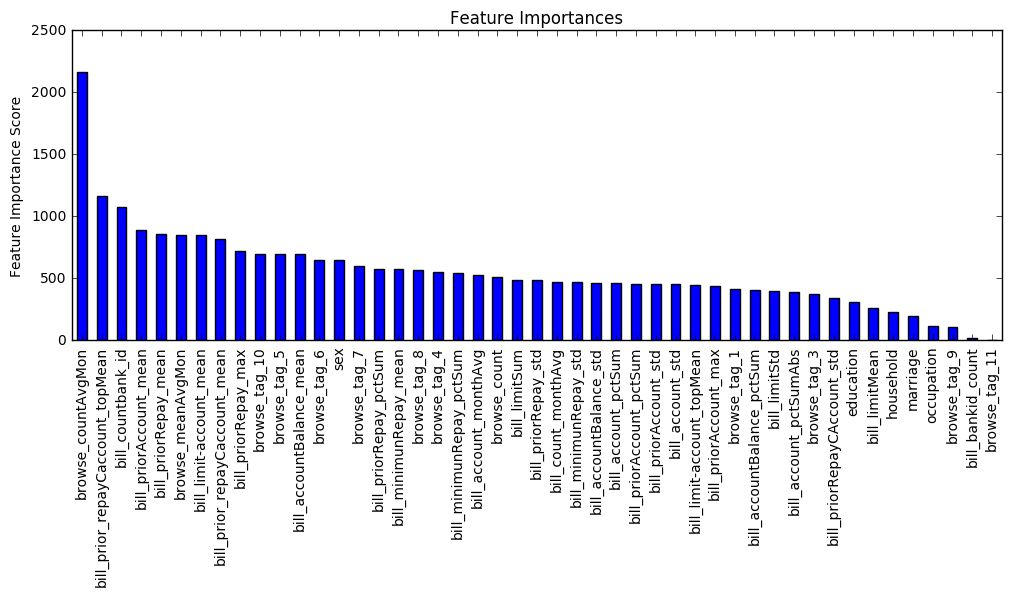

In [48]:
#Import libraries:
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
train_y = train.label
target_name = 'label'
IDcol = 'userid'
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=10, early_stopping_rounds=100):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target_name].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['label'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['label'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['label'], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
#Choose all predictors except target & IDcols
predictors = [i for i in train.columns if i not in [target_name, IDcol]]
xgb1 = XGBClassifier(
    learning_rate =0.01,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=5,
    gamma=0.2,
    scale_pos_weight= float(len(train_y)-sum(train_y))/float(sum(train_y)),
    reg_alpha=1e-5,
    subsample=0.8,
    colsample_bytree=0.9,
    objective= 'binary:logistic',
    nthread=4,
    
    seed=27)
modelfit(xgb1, train, predictors)
xgb1.fit(train2[predictors],train2[target_name])
test2 = test2.drop('userid',axis=1)
y_prob1 = xgb1.predict_proba(test2)

In [20]:
y_pre_prob = pd.DataFrame(y_prob).iloc[:,1]
y_pre_prob.index = test.index
y_pre_prob = y_pre_prob.reset_index()
y_pre_prob.columns = ['userid','probability']
y_pre_prob.to_csv('result_2-12-1.csv',index=False)


In [63]:
# test2 = test2.reset_index().drop('userid',axis=1)
# y_prob2 = xgb1.predict_proba(test2[predictors])
# print train2[predictors].shape
# test2.shape
y_pre_prob2 = pd.DataFrame(y_prob2).iloc[:,1]
y_pre_prob2.index = p.userid
y_pre_prob2 = y_pre_prob2.reset_index()
y_pre_prob2.columns = ['userid','probability']
y_pre_prob2.to_csv('result_2-12-2.csv',index=False)

In [87]:
y1=y_pre_prob.set_index('userid')
y1.index=test.index
y2=y_pre_prob2.set_index('userid')
print y1.shape
print y2.shape
index_j = set(y2.index).difference(set(y1.index))
print pd.concat([y1,y2.loc[index_j,:]]).shape


(11381, 1)
(13899, 1)
(13899, 1)


In [91]:
re=pd.concat([y1,y2.loc[index_j,:]])
re.to_csv('result2-11.csv')

### Tuning parameters
调参时候设置大一点的学习率，有利于快速调参和防止进入局部最优，调完参后再设置小的学习率能够更好的拟合

In [327]:
param_test1 = {
#     'max_depth':range(3,10,2),
#     'min_child_weight':range(1,6,2), #gamma=0,max_depth=5,min_child_weight=1
#     'max_depth':[4,5,6],
#     'min_child_weight':[2,3,4],
#     'gamma':[i/10.0 for i in range(0,5)],
#     'subsample':[i/10.0 for i in range(6,10)],
#     'colsample_bytree':[i/10.0 for i in range(6,10)]
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                                  min_child_weight=5, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.73994, std: 0.01694, params: {'reg_alpha': 1e-05},
  mean: 0.73989, std: 0.01787, params: {'reg_alpha': 0.01},
  mean: 0.73856, std: 0.01737, params: {'reg_alpha': 0.1},
  mean: 0.73965, std: 0.01747, params: {'reg_alpha': 1},
  mean: 0.72235, std: 0.02275, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 0.73994045816560572)

In [26]:
train=pd.read_csv('train_num_billIndex.csv')
test=pd.read_csv('test_num_billIndex.csv')

In [ ]:
import os,random,cPickle
# os.mkdir('featurescore_rank')
#类别不平衡  2198个正样本（违约），27802个负样本

# train = pd.read_csv('../../data/train/train_x_rank.csv')
# train_target = pd.read_csv('../../data/train/train_master.csv',encoding='gb18030')[['Idx','target']]
# train = pd.merge(train,train_target,on='Idx')
train_y = train.label
train_x = train.drop(['userid','label'],axis=1)
dtrain = xgb.DMatrix(train_x, label=train_y)

# test = pd.read_csv('../../data/test/test_x_rank.csv')
# test = test.reset_index()
test = test.drop('userid',axis=1)
dtest = xgb.DMatrix(test)

# train_test = pd.concat([train,test])
# train_test.to_csv('rank_feature.csv',index=None)
# print train_test.shape
'''
params={
    	'booster':'gbtree',
    	'objective': 'rank:pairwise',
    	'scale_pos_weight': float(len(train_y)-sum(train_y))/float(sum(train_y)),
        'eval_metric': 'auc',
    	'gamma':0.1,
    	'max_depth':6,
    	'lambda':500,
        'subsample':0.6,
        'colsample_bytree':0.3,
        'min_child_weight':0.2, 
        'eta': 0.04,
    	'seed':1024,
    	'nthread':8
        }
xgb.cv(params,dtrain,num_boost_round=1100,nfold=10,metrics='auc',show_progress=3,seed=1024)#733
'''
def pipeline(iteration,random_seed,gamma,max_depth,lambd,subsample,colsample_bytree,min_child_weight):
    params={
        'booster':'gbtree',
	    'objective': 'rank:pairwise',
	    'scale_pos_weight': float(len(train_y)-sum(train_y))/float(sum(train_y)),
	    'eval_metric': 'auc',
	    'gamma':gamma,
	    'max_depth':max_depth,
	    'lambda':lambd,
	    'subsample':subsample,
	    'colsample_bytree':colsample_bytree,
	    'min_child_weight':min_child_weight, 
	    'eta': 0.2,
	    'seed':random_seed,
	    'nthread':4
	 }

    watchlist  = [(dtrain,'train')]
    model = xgb.train(params,dtrain,num_boost_round=700,evals=watchlist)
    #model.save_model('./model/xgb{0}.model'.format(iteration))
    #predict test set
    #test_y = model.predict(dtest)
    #test_result = pd.DataFrame(test_Idx,columns=["Idx"])
    #test_result["score"] = test_y
    #test_result.to_csv("./preds/xgb{0}.csv".format(iteration),index=None,encoding='utf-8')
    
    #save feature score
    feature_score = model.get_fscore()
    feature_score = sorted(feature_score.items(), key=lambda x:x[1],reverse=True)
    fs = []
    for (key,value) in feature_score:
        fs.append("{0},{1}\n".format(key,value))
    
    with open('./featurescore_rank/feature_score_{0}.csv'.format(iteration),'w') as f:
        f.writelines("feature,score\n")
        f.writelines(fs)


if __name__ == "__main__":
    random_seed = range(10000,20000,100)
    gamma = [i/1000.0 for i in range(0,300,3)]
    max_depth = [5,6,7]
    lambd = range(400,600,2)
    subsample = [i/1000.0 for i in range(500,700,2)]
    colsample_bytree = [i/1000.0 for i in range(550,750,4)]
    min_child_weight = [i/1000.0 for i in range(250,550,3)]
    
    random.shuffle(random_seed)
    random.shuffle(gamma)
    random.shuffle(max_depth)
    random.shuffle(lambd)
    random.shuffle(subsample)
    random.shuffle(colsample_bytree)
    random.shuffle(min_child_weight)
    
    with open('r_params.pkl','w') as f:
        cPickle.dump((random_seed,gamma,max_depth,lambd,subsample,colsample_bytree,min_child_weight),f)

    for i in range(36):
        pipeline(i,random_seed[i],gamma[i],max_depth[i%3],lambd[i],subsample[i],colsample_bytree[i],min_child_weight[i])


[0]	train-auc:0.760596
[1]	train-auc:0.764738
[2]	train-auc:0.765445
[3]	train-auc:0.770404
[4]	train-auc:0.770883
[5]	train-auc:0.771705
[6]	train-auc:0.780212
[7]	train-auc:0.783061
[8]	train-auc:0.78596
[9]	train-auc:0.789006
[10]	train-auc:0.790979
[11]	train-auc:0.794702
[12]	train-auc:0.797649
[13]	train-auc:0.799548
[14]	train-auc:0.802062
[15]	train-auc:0.803427
[16]	train-auc:0.805661
[17]	train-auc:0.807424
[18]	train-auc:0.809568
[19]	train-auc:0.810811
[20]	train-auc:0.811792
[21]	train-auc:0.813693
[22]	train-auc:0.814734
[23]	train-auc:0.816329
[24]	train-auc:0.818458
[25]	train-auc:0.820203
[26]	train-auc:0.82169
[27]	train-auc:0.822393
[28]	train-auc:0.823726
[29]	train-auc:0.824433
[30]	train-auc:0.825748
[31]	train-auc:0.826702
[32]	train-auc:0.827319
[33]	train-auc:0.828213
[34]	train-auc:0.829018
[35]	train-auc:0.829795
[36]	train-auc:0.830558
[37]	train-auc:0.831167
[38]	train-auc:0.832323
[39]	train-auc:0.833265
[40]	train-auc:0.833919
[41]	train-auc:0.835002
[42]

In [34]:
#coding=utf-8

import pandas as pd
import xgboost as xgb
import os,random,cPickle



# train = pd.read_csv('../data/8file_train_sample.csv')
train_y = train.label
train_x = train.drop(['label','userid'],axis=1)

# test = pd.read_csv('../data/8file_test.csv')
test_userid = test.userid
test_x = test.drop('userid',axis=1)

# all_features =  list(train_x.columns)#1439
# features_1 = list(pd.read_csv('../feature_select/feature_score.csv')['feature'])#1157
# features_2 = [feature for feature in all_features if feature not in features_1]#282


def pipeline(iteration,random_seed,max_depth,lambd,subsample,colsample_bytree,min_child_weight,n_feature):
#     fs = features_1 + features_2[0:n_feature] 
    fs=test_x.columns
    train_selected = train_x[fs]
    test_selected = test_x[fs]

    print train_selected.shape,test_selected.shape

    dtrain = xgb.DMatrix(train_selected,label=train_y)
    dtest = xgb.DMatrix(test_selected)
    
    del train_selected,test_selected

    params={
    	'booster':'gbtree',
    	'objective': 'binary:logistic',
        'eval_metric': 'auc',
    	'max_depth':max_depth,
    	'lambda':lambd,
        'subsample':subsample,
        'colsample_bytree':colsample_bytree,
        'min_child_weight':min_child_weight, 
        'eta': 0.025,
    	'seed':random_seed,
    	'nthread':8
        }
    
    """
    #通过cv找最佳的nround
    cv_log = xgb.cv(params,dtrain,num_boost_round=5000,nfold=8,metrics='auc',early_stopping_rounds=50,show_progress=3,seed=random_seed)
    bst_auc= cv_log['test-auc-mean'].max()
    cv_log['nb'] = cv_log.index
    cv_log.index = cv_log['test-auc-mean']
    nround = cv_log.nb.to_dict()[bst_auc]
    """

    if max_depth==4:
        nround = 1500
    elif max_depth==5:
        nround = 1000

    watchlist  = [(dtrain,'train')]
    model = xgb.train(params,dtrain,num_boost_round=nround,evals=watchlist)

    #predict test set
    test_y = model.predict_proba(dtest).iloc[:,1]
    test_result = pd.DataFrame(test_userid,columns=["userid"])
    test_result["probability"] = test_y
    test_result.to_csv("./test/xgb{0}.csv".format(iteration),index=None,encoding='utf-8')



if __name__ == "__main__":
#     os.mkdir('test')
    random_seed = range(2016)
    max_depth = [4,5]
    lambd = range(5,41)
    subsample = [i/1000.0 for i in range(700,800)]
    colsample_bytree = [i/1000.0 for i in range(700,800)]
    min_child_weight = [i/100.0 for i in range(150,250)]
    n_feature = range(150,282,2)

    random.shuffle(random_seed)
    random.shuffle(max_depth)
    random.shuffle(lambd)
    random.shuffle(subsample)
    random.shuffle(colsample_bytree)
    random.shuffle(min_child_weight)
    random.shuffle(n_feature)
    
    with open('params.pkl','w') as f:
        cPickle.dump((random_seed,max_depth,lambd,subsample,colsample_bytree,min_child_weight,n_feature),f)
    
    for i in range(36):
        print "iter:",i
        pipeline(i,random_seed[i],max_depth[i%2],lambd[i],subsample[i],colsample_bytree[i],min_child_weight[i],n_feature[i])


iter: 0
(45149, 48) (11381, 48)
[0]	train-auc:0.719112
[1]	train-auc:0.738657
[2]	train-auc:0.739793
[3]	train-auc:0.745684
[4]	train-auc:0.746344
[5]	train-auc:0.74882
[6]	train-auc:0.751413
[7]	train-auc:0.751171
[8]	train-auc:0.751395
[9]	train-auc:0.751927
[10]	train-auc:0.759734
[11]	train-auc:0.759904
[12]	train-auc:0.759675
[13]	train-auc:0.761558
[14]	train-auc:0.761932
[15]	train-auc:0.76214
[16]	train-auc:0.762832
[17]	train-auc:0.763895
[18]	train-auc:0.764638
[19]	train-auc:0.765052
[20]	train-auc:0.765385
[21]	train-auc:0.765889
[22]	train-auc:0.766231
[23]	train-auc:0.767023
[24]	train-auc:0.767858
[25]	train-auc:0.768959
[26]	train-auc:0.769297
[27]	train-auc:0.769599
[28]	train-auc:0.770108
[29]	train-auc:0.770241
[30]	train-auc:0.771119
[31]	train-auc:0.771292
[32]	train-auc:0.771583
[33]	train-auc:0.771949
[34]	train-auc:0.772422
[35]	train-auc:0.77243
[36]	train-auc:0.772728
[37]	train-auc:0.772799
[38]	train-auc:0.772757
[39]	train-auc:0.773106
[40]	train-auc:0.7733

AttributeError: 'Booster' object has no attribute 'predict_proba'